In [475]:
import meshio
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import FaceToEdge
import matplotlib.pyplot as plt

In [476]:
class TetraToEdge(object):
    r"""Converts mesh tetras :obj:`[4, num_tetras]` to edge indices
    :obj:`[2, num_edges]`.
    Args:
        remove_tetras (bool, optional): If set to :obj:`False`, the tetra tensor
            will not be removed.
    """

    def __init__(self, remove_tetras=True):
        self.remove_tetras = remove_tetras

    def __call__(self, data):
        if data.tetra is not None:
            tetra = data.tetra
            edge_index = torch.cat([tetra[:2], tetra[1:3, :], tetra[-2:], tetra[::2], tetra[::3], tetra[1::2]], dim=1)
            edge_index = to_undirected(edge_index, num_nodes=data.num_nodes)

            data.edge_index = edge_index
            if self.remove_tetras:
                data.tetra = None

        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [477]:
def from_meshio(mesh, mesh_type='2D'):
    r"""Converts a :.msh file to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        mesh (meshio.read): A :obj:`meshio` mesh.
    """

    if meshio is None:
        raise ImportError('Package `meshio` could not be found.')

    pos = torch.from_numpy(mesh.points).to(torch.float)
    if mesh_type == '3D':
        tetra = torch.from_numpy(mesh.cells_dict['tetra']).to(torch.long).t().contiguous()
        return Data(pos=pos, tetra=tetra)
    elif mesh_type == '2D':
        face = torch.from_numpy(mesh.cells_dict['triangle']).to(torch.long).t().contiguous()
        return Data(pos=pos, face=face)

In [478]:
mesh_type = '2D'
filename = '../meshes/planar_fine.msh'
prob_reject = 0.988

mesh = meshio.read(filename)

data = from_meshio(mesh, mesh_type=mesh_type)
if mesh_type == '2D':
    data = FaceToEdge(remove_faces=False)(data)
else:
    data = TetraToEdge()(data)

# These are the rays
o = torch.tensor([[0.5, 0.5, 0.], [0.2, -0.5, 0.]])
d = torch.tensor([[-1., -1., 0.], [-1., 0.8, 0.]])

#distn = torch.norm(torch.cross(o - data.pos.unsqueeze(1), d.repeat(data.num_nodes, 1, 1), dim=-1), dim=-1) / torch.norm(d, dim=1)
#distn = distn / distn.max()  # Normalize
#data.probs = (1 - distn)
#data.probs = (data.probs > 0.85).float()

### Traza el rayo

#### 1. Distancia R0 - Bi

Primero sacamos las coordenadas de cada triángulo. Debería ser [Num triángulos, 3 (vértices), 3 (coordenadas)]

In [479]:
triangles = data.face.permute(1, 0)

In [480]:
triangles.shape

torch.Size([9233, 3])

In [481]:
triangles_coords = data.pos[triangles]

In [482]:
triangles_coords.shape

torch.Size([9233, 3, 3])

Después el centroide de cada uno y lo guardamos en el data

In [483]:
centroids = torch.sum(triangles_coords, dim=1) / 3

In [484]:
data.centroids = centroids

In [485]:
data.centroids.shape

torch.Size([9233, 3])

Comprobamos que es un centro

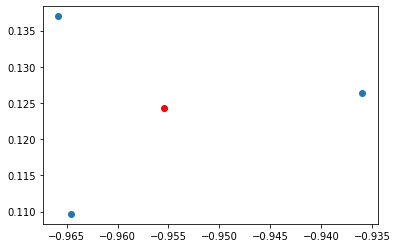

In [486]:
plt.scatter(triangles_coords[0,:,0], triangles_coords[0,:,1])
plt.scatter(centroids[0,0], centroids[0,1], color='red')

Calculamos la distancia desde el origen del rayo a cada centroide

In [487]:
(data.centroids - o.unsqueeze(1)).shape

torch.Size([2, 9233, 3])

In [488]:
dist_r_c = torch.norm(data.centroids - o.unsqueeze(1), dim=-1)

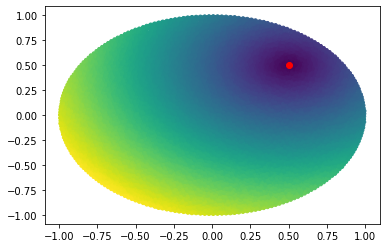

In [489]:
plt.scatter(centroids[:,0], centroids[:,1], c=dist_r_c[0], s=10)
plt.scatter(o[0, 0], o[0, 1], color='red')

Todo tiene sentido.

Distancia rayo-centroides

In [490]:
distn = torch.norm(torch.cross(o - data.centroids.unsqueeze(1), d.repeat(data.num_faces, 1, 1), dim=-1), dim=-1) / torch.norm(d, dim=-1)
distn = distn / distn.max()  # Normalize
data.probs = ((1 - distn) > prob_reject).float()

In [491]:
data.probs.shape

torch.Size([9233, 2])

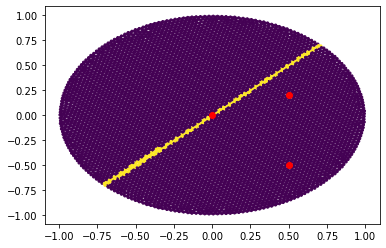

In [492]:
plt.scatter(centroids[:,0], centroids[:,1], c=data.probs[:,0], s=5)
plt.scatter(o[0], o[1], color='red')

#### 2. Sacar el triángulo en el que nos encontramos

In [493]:
dist_r_c.shape

torch.Size([2, 9233])

In [494]:
o_triangle = dist_r_c.argmin(1)

In [495]:
o_triangle

tensor([1756, 7809])

In [496]:
triangles_coords[o_triangle,:,:2]

tensor([[[ 0.5025,  0.4917],
         [ 0.5097,  0.5189],
         [ 0.4825,  0.5115]],

        [[ 0.1974, -0.4768],
         [ 0.1902, -0.5041],
         [ 0.2174, -0.4967]]])

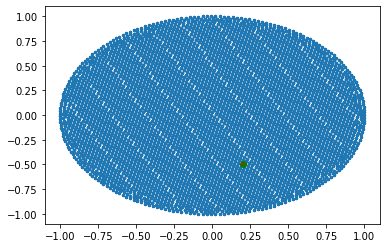

In [497]:
plt.figure()
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

t1 = plt.Polygon(triangles_coords[o_triangle,:,:2][1], color='red', alpha=0.4)
plt.gca().add_patch(t1)
plt.scatter(o[1,0], o[1,1], color='green')

#### 3. Intersección de Rd con las aristas y determinación del siguiente triángulo

In [498]:
import numpy as np
from itertools import combinations

In [499]:
def line_ray_intersection_point(rayOrigin, rayDirection, point1, point2):
    # Ray-Line Segment Intersection Test in 2D
    # http://bit.ly/1CoxdrG
    v1 = (rayOrigin - point1)[:,:-1]
    v2 = (point2 - point1)[:,:-1]
    v3 = np.stack([-np.array(rayDirection[:, 1]), np.array(rayDirection[:, 0])], axis=1)
    dotprod = np.einsum('ij, ij -> i', v2, v3)
    t1 = np.cross(v2, v1, axis=1) / dotprod
    t2 = np.einsum('ij, ij -> i', v1, v3) / dotprod
    return torch.tensor((t1 >= 0) * (t2 >= 0) * (t2 <= 1))

In [500]:
idx_vertex_origin_triangle = triangles[o_triangle]
vertex_origin_triangle = triangles_coords[o_triangle]  # Only for plotting

In [501]:
combs = [[0, 1, 2], [0, 2, 1], [1, 2, 0]]
idx_vertex = torch.zeros((o.shape[0], 2))  # Batch size
for idx_p1, idx_p2, out in combs:
    p1 = data.pos[idx_vertex_origin_triangle[:, idx_p1]]
    p2 = data.pos[idx_vertex_origin_triangle[:, idx_p2]]
    
    intersection = line_ray_intersection_point(centroids[o_triangle], d, p1, p2)

    if intersection.any():        
        idx_vertex += intersection.unsqueeze(1) * idx_vertex_origin_triangle[:,[idx_p1, idx_p2]]

In [502]:
idx_vertex

tensor([[ 763.,  761.],
        [4071., 4134.]])

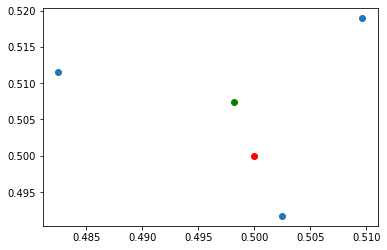

In [503]:
plt.scatter(vertex_origin_triangle[0,:,0], vertex_origin_triangle[0,:,1])
plt.scatter(o[0,0], o[0,1], color='red')
plt.scatter(centroids[o_triangle][0,0], centroids[o_triangle][0, 1], color='green')

Ya sabemos la arista, ahora hay que encontrar el siguiente triángulo.

In [504]:
o_triangle

tensor([1756, 7809])

Esto funciona, pero es feísimo y o(n)

In [505]:
next_triangle = torch.zeros((o.shape[0]), dtype=torch.long)
for i, r in enumerate(idx_vertex):
    next_triangle[i] = torch.nonzero((triangles == r[0]).any(1) * (triangles == r[1]).any(1) * 
                              (triangles != idx_vertex_origin_triangle[i]).any(1))[0,0]

In [506]:
triangles_visited = o_triangle.clone().unsqueeze(1).long()
distances = torch.zeros_like(triangles_visited)

triangles_visited = torch.cat([triangles_visited, next_triangle.unsqueeze(1)], dim=-1)
distances = torch.cat([distances, torch.norm(centroids[o_triangle] - centroids[next_triangle.long()], dim=-1, keepdim=True)])

In [507]:
triangles_visited

tensor([[1756, 4945],
        [7809, 7235]])

In [508]:
triangles_coords.shape

torch.Size([9233, 3, 3])

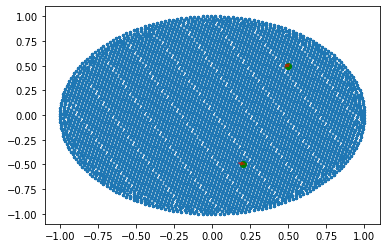

In [509]:
plt.figure()
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

for r in triangles_visited:
    for t in r:
        t1 = plt.Polygon(triangles_coords[t,:,:2], color='red', alpha=0.4)
        plt.gca().add_patch(t1)
    
plt.scatter(o[0,0], o[0,1], color='green')
plt.scatter(o[1,0], o[1,1], color='green')

#### 4. Encontrar triángulos alrededor 

In [510]:
def calculate_neighbours(triangles):
    neighbours = torch.empty((triangles.shape[0], 3), dtype=torch.long)
    combs = [[0, 1, 2], [0, 2, 1], [1, 2, 0]]
    for i_face, face in enumerate(triangles):
        neighbours_triangle = []
        for i1, i2, out in combs:
            v1 = face[i1]
            v2 = face[i2]
            vout = face[out]

            edge_neighbour = torch.nonzero((triangles == v1).any(1) * (triangles == v2).any(1) * (triangles != vout).all(1))[:,0]

            if len(edge_neighbour) == 0:
                edge_neighbour = -1
            elif len(edge_neighbour) > 1:
                raise ValueError('Something is wrong')
            else:
                edge_neighbour = edge_neighbour.item()
                
            neighbours_triangle.append(edge_neighbour)
        neighbours[i_face] = torch.tensor(neighbours_triangle, dtype=torch.long)
    return neighbours

In [511]:
data.neighbours = calculate_neighbours(data.face.permute(1, 0))

In [512]:
data.neighbours

tensor([[ 162,   72,   57],
        [4356,   90,   16],
        [  34,  138, 1742],
        ...,
        [9116, 8987, 9151],
        [9215, 8988, 8918],
        [9136, 8875, 9218]])

Asignar a todos los triángulos una probabilidad según la media de sus vértices

In [513]:
triangles.shape

torch.Size([9233, 3])

In [514]:
probs_triangle = data.probs[triangles].mean(axis=1)

In [515]:
data.probs.shape

torch.Size([9233, 2])

In [516]:
probs_triangle = probs_triangle.permute(1,0)

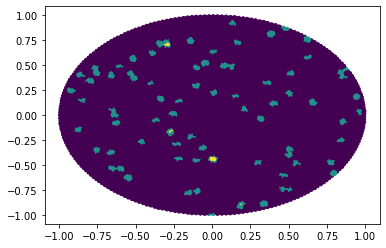

In [517]:
plt.scatter(centroids[:,0], centroids[:,1], c=probs_triangle[1], s=10)

In [518]:
data.probs = data.probs.permute(1,0)

#### 5. Bucle para terminar el proceso 

In [519]:
def cosine_similarity(x, y):
    '''
    x: Momentum vector. [Batch x Coordinates]
    y: Vector from the origin of the triangle to the centroids of the neighbours. [Batch x Neighbours x Coordinates]
    '''
    similarity = torch.einsum('bc,bvc->bv', x, y) / (x.norm(dim=1) * y.norm(dim=(1,2))).unsqueeze(1)
    
    return similarity

In [520]:
def evolve(graph, visited, ray_direction):
    while True and visited.shape[-1] < 1000:
        last_triangle = visited[:, -2]
        current_triangle = visited[:, -1]
        current_neigh = graph.neighbours[current_triangle]

        if -1 in current_neigh:
            break

        y = graph.centroids[current_neigh] - graph.centroids[current_triangle].unsqueeze(1)  # B x Vecinos x Componentes
        if visited.shape[-1] > 2:
            momentum_vector = graph.centroids[current_triangle] - graph.centroids[last_triangle]  # B x Componentes
        else:
            momentum_vector = ray_direction

        momentum = torch.einsum('bc,bvc->bv', momentum_vector, y) / (
                    momentum_vector.norm(dim=1) * y.norm(dim=(1, 2))).unsqueeze(1)
        momentum = (momentum > 0).float()
        if not momentum.any():
            print('No more neighbours found')
            break

        probs_neighbours = torch.gather(graph.probs, 1, current_neigh) * momentum

        next_triangle = torch.gather(current_neigh, 1, probs_neighbours.argmax(1).unsqueeze(1)).squeeze(1)

        visited = torch.cat([visited, next_triangle.unsqueeze(1)], dim=-1)
    return visited

In [521]:
def evolve_mom(data, visited, gamma=1., steps=100):
    last_direction = d.clone()
    last_mu = torch.zeros((2, 3))  # Batch size!
    for i in range(steps):
        last_triangle = visited[:,-2]
        current_triangle = visited[:,-1]
        current_neigh = data.neighbours[current_triangle]

        if -1 in current_neigh:
            break
            
        y = centroids[current_neigh] - centroids[current_triangle].unsqueeze(1)  # B x Vecinos x Componentes
        if i > 2:
            last_direction = centroids[current_triangle] - centroids[last_triangle]
        #if visited.shape[-1] > 3:
        #    momentum_vector = centroids[current_triangle] - centroids[visited[:,-3]]  # B x Componentes
        #else:
        #    momentum_vector = d
        
        current_mu = cosine_similarity(last_direction, y)
        mu = current_mu + gamma * last_mu
        #print(mu)

        probs_neighbours = torch.gather(data.probs, 1, current_neigh)
        coeff = probs_neighbours * mu
        #print(coeff)

        next_triangle = torch.gather(current_neigh, 1, coeff.argmax(1).unsqueeze(1))

        visited = torch.cat([visited, next_triangle], dim=-1)
        last_mu = mu
    return visited

In [522]:
vis = evolve(data, triangles_visited.clone(), d)
# vis = evolve_mom(data, triangles_visited.clone(), gamma=0.5, steps=1000)

(-0.25, -0.75)

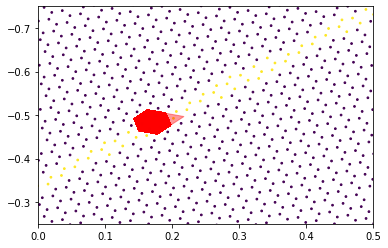

In [532]:
#plt.figure(figsize=(12,10))
#plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)
plt.scatter(centroids[:,0], centroids[:,1], c=data.probs[1], s=3)

for r in vis:
    for t in r:
        t1 = plt.Polygon(triangles_coords[t,:,:2], color='red', alpha=0.4)
        plt.gca().add_patch(t1)
    
plt.scatter(o[0,0], o[0,1], color='green')
#plt.scatter(o[1,0], o[1,1], color='green')
#plt.scatter(o[2,0], o[2,1], color='green')
plt.xlim([0.00, 0.50])
plt.ylim([-0.25, -0.75])

#### Tomar valores intermedios en una función a trozos 

In [524]:
from scipy import interpolate

El orden es MUY importante

In [525]:
rays = data.centroids[vis]

In [526]:
for r in rays:
    r_sorted = r #[r[:, 0].sort()[1]]

    x = r_sorted[:,0]
    y = r_sorted[:,1]
    f = interpolate.interp1d(x, y)
    xnew = torch.arange(r_sorted[:,0].min(), r_sorted[:,0].max(), 0.01)
    ynew = f(xnew)
    break

C:\Users\Javier\AppData\Local\Continuum\anaconda3\envs\torch18\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


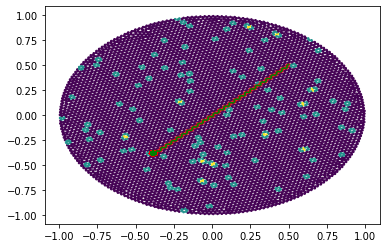

In [527]:
#plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)
plt.scatter(centroids[:,0], centroids[:,1], c=probs_triangle[0], s=3)

triangles_plot = vis

for t in triangles_plot[0]:
    t1 = plt.Polygon(triangles_coords[t,:,:2], color='red', alpha=0.4)
    plt.gca().add_patch(t1)

plt.plot(x, y, color='green')

In [528]:
x

tensor([ 0.4982,  0.4868,  0.4910,  0.4796,  0.4639,  0.4524,  0.4567,  0.4452,
         0.4295,  0.4181,  0.4224,  0.4109,  0.3952,  0.3837,  0.3880,  0.3766,
         0.3608,  0.3494,  0.3537,  0.3422,  0.3265,  0.3150,  0.3193,  0.3079,
         0.2921,  0.2807,  0.2850,  0.2735,  0.2578,  0.2463,  0.2506,  0.2392,
         0.2234,  0.2120,  0.2163,  0.2048,  0.1891,  0.1777,  0.1819,  0.1705,
         0.1548,  0.1433,  0.1476,  0.1361,  0.1204,  0.1090,  0.1132,  0.1018,
         0.0861,  0.0746,  0.0789,  0.0675,  0.0517,  0.0403,  0.0446,  0.0331,
         0.0174,  0.0059,  0.0102, -0.0012, -0.0170, -0.0284, -0.0241, -0.0356,
        -0.0513, -0.0628, -0.0585, -0.0699, -0.0857, -0.0971, -0.0928, -0.1043,
        -0.1200, -0.1315, -0.1272, -0.1386, -0.1543, -0.1658, -0.1615, -0.1730,
        -0.1887, -0.2001, -0.1959, -0.2073, -0.2230, -0.2345, -0.2302, -0.2417,
        -0.2574, -0.2688, -0.2645, -0.2760, -0.2917, -0.3032, -0.2989, -0.3103,
        -0.3261, -0.3375, -0.3332, -0.34

In [529]:
y

tensor([ 0.5074,  0.4958,  0.4801,  0.4686,  0.4727,  0.4612,  0.4455,  0.4339,
         0.4380,  0.4265,  0.4108,  0.3992,  0.4034,  0.3918,  0.3761,  0.3646,
         0.3687,  0.3572,  0.3415,  0.3299,  0.3340,  0.3225,  0.3068,  0.2952,
         0.2994,  0.2878,  0.2721,  0.2606,  0.2647,  0.2532,  0.2375,  0.2259,
         0.2300,  0.2185,  0.2028,  0.1912,  0.1954,  0.1838,  0.1681,  0.1566,
         0.1607,  0.1491,  0.1335,  0.1219,  0.1260,  0.1145,  0.0988,  0.0872,
         0.0914,  0.0798,  0.0641,  0.0526,  0.0567,  0.0451,  0.0295,  0.0179,
         0.0220,  0.0105, -0.0052, -0.0168, -0.0126, -0.0242, -0.0399, -0.0514,
        -0.0473, -0.0589, -0.0746, -0.0861, -0.0820, -0.0935, -0.1092, -0.1208,
        -0.1166, -0.1282, -0.1439, -0.1554, -0.1513, -0.1629, -0.1786, -0.1901,
        -0.1860, -0.1975, -0.2132, -0.2248, -0.2206, -0.2322, -0.2479, -0.2594,
        -0.2553, -0.2669, -0.2826, -0.2941, -0.2900, -0.3015, -0.3172, -0.3288,
        -0.3246, -0.3362, -0.3519, -0.36

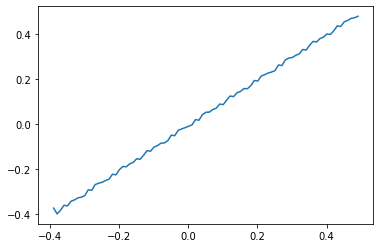

In [530]:
#plt.plot(x,y)
plt.plot(xnew, ynew)